# This program detects plagiarism among student source code files. The students that copied from the example codes provided by the teacher are not flagged.

In [357]:
import platform
from pathlib import Path
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import itertools as it
from operator import itemgetter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [358]:
# these are subject to changes
file_extension = "*" + ".pde" # the extension of the source code files 
directory_path = r"C:\Users\Samuel\Desktop\testsPDE"
#directory_path = r"C:/Users/Samuel/Desktop/Assignment 4 (File responses)"

In [359]:
# some selected keywords peculiar to the programming language's synthax
language_keywords = ['background','boolean','constrain','doesoverlap','draw','ellipse','else','false','fill','float','fullscreen','if','int','maxx','maxy','mousepressed','mousex','mousey','rect','return','setup','string','stroke','screenwidth','screenheight','text','textsize','true','void','displaypaddles', 'movepaddles', 'checkleftpaddle', 'checkrightpaddle', 'displayball', 'displayscores', 'moveball', 'checkwall', 'setgameon']

In [360]:
# CONSTANT THRESHOLD
THRESHOLD = 0.51
ERROR_MARGIN = 0.1

# variables declaraton and initialisation
outer_index, inner_index, leading_diag_element, leading_diag_element_idx, leading_diag_element_nested_index, doc = [], [], [], [], [], []

# The file name of the lesson note containing code snippets that students could copy to use in their assignment
example_code_file_name = "ASSFOURHELP" # The RHS string could be empty if this file is not available, otherwise, the name MUST have UPPERCASE letters all through.

In [361]:
# these imports all source code file paths present in the specified working directory    
files = [file.parent/file.name for file in Path(directory_path).glob(file_extension)]
file_paths = sorted([str(i) for i in files]) 

In [362]:
# this stores the contents of each code files(which is a string) in a list
for file_path in file_paths:
	with open(file_path, "r") as file_object:
		texts = file_object.read().replace("\n", " ")
		doc.append(texts)

In [363]:
# this takes care of path separator differences across os
if platform.system() == "Windows":
    sep = "\\"
else:
    sep = "/"

# this extracts the name of the code files
doc_names = [i[i.rfind(sep):i.rfind(".")].lstrip(sep) for i in file_paths]

In [364]:
cv = TfidfVectorizer(doc, stop_words = language_keywords, ngram_range = (2, 5))
word_count_vector = cv.fit_transform(doc)

# sklearn cosine similarity matrix is converted to python's list of lists here.The precision of elements in the LoL are automatically increased unlike that of sklearn.
sim_matrix = cosine_similarity(word_count_vector)
similarity_matrix = sim_matrix.tolist()

# these generates a replica matrix with elements having similar precision to sklearn's own
flat = list(it.chain.from_iterable(similarity_matrix))
round_flat = [round(i, 7) for i in flat]
replica_matrix = [round_flat[i:i+len(similarity_matrix)] for i in range(0, len(round_flat), len(similarity_matrix))]

# A "list of list" is de-nested here
flat_replica_matrix = list(it.chain.from_iterable(replica_matrix))

In [365]:
# these generates two separate lists each containing row & column numbers in a specific pattern peculiar to a matrix
for idx, i in enumerate(replica_matrix, 1):
	for num in range(0, len(similarity_matrix)):
		outer_index.append(idx)
	for index, _ in enumerate(i, 1):
		inner_index.append(index)

In [366]:
# the row, column number of each elements in the similarity matrix of use are stored in a list here
nested_index = [(i,j) for i, j in zip(outer_index, inner_index)]

In [367]:
# Since the leading diagonal element of the cosine similarity matrix is of no use, the below statements extracts these elements and their indexes 
for i in range(0, len(flat_replica_matrix), len(replica_matrix)+1):
    leading_diag_element.append(flat_replica_matrix[i])
    leading_diag_element_idx.append(i)

In [368]:
# these extracts the elements that are not in the leading diagonal     
temp_1 = [i for i, _ in enumerate(flat_replica_matrix)]
temp_2 = list(set(temp_1)-set(leading_diag_element_idx))
remainder_elements = [flat_replica_matrix[i] for i in temp_2] 

In [369]:
# these extracts the row, column number of the elements present in the leading diagonal of the cosine similarity matrix of use
for i in range(0, len(nested_index), len(replica_matrix)+1):
	leading_diag_element_nested_index.append(nested_index[i])

In [370]:
# this extracts the the row, column number of the elements NOT present in the leading diagonal of the cosine similarity matrix of use
remainder_elements_nested_idx = [i for i in nested_index if i not in leading_diag_element_nested_index] 

# this extracts the UNIQUE row, column number of the elements NOT present in the leading diagonal of the cosine similarity matrix of use
unique_rem_elements_nested_idx = {tuple(sorted(i)) for i in remainder_elements_nested_idx}

In [371]:
# elements are mapped to the nested indexes in this data structure
data_struct = {i:j for i,j in zip(remainder_elements_nested_idx, remainder_elements)} 

# this extracts the UNIQUE elements
unique_remainder_elements = [data_struct.get(i) for i in unique_rem_elements_nested_idx]

# this maps the source code file names to a unique serial number starting from 1
hash_table = {i:j for i, j in zip(list(set(outer_index)), doc_names)} 

# this groups the source file names in unique pairs
unique_rem_elements_matched_names = [tuple((hash_table.get(i[0]), hash_table.get(i[1]))) for i in unique_rem_elements_nested_idx] 	 

# mapping unique values to source file pairs
unique_elements_data = {i:j for i,j in zip(unique_rem_elements_matched_names, unique_remainder_elements)}

# sorting of results in descending order
reversed_unique_elements_data = dict(sorted(unique_elements_data.items(), key = itemgetter(1), reverse = True))

# list of student files that copied from the lesson note containing code snippets
example_code_mirror_files = [i[1] for i in reversed_unique_elements_data if reversed_unique_elements_data.get(i) > THRESHOLD and i[0] == example_code_file_name]
temp_3 = {i[1]:reversed_unique_elements_data.get(i) for i in reversed_unique_elements_data.keys() if i[0] == example_code_file_name and i[1] in example_code_mirror_files}

print(f"Total source code files: {len(doc_names)}")
print()

Total source code files: 13



In [372]:
count = 0
for i in reversed_unique_elements_data.keys():
    if i[0] != example_code_file_name and reversed_unique_elements_data.get(i) > THRESHOLD:
        try:
            if reversed_unique_elements_data.get(i) > (temp_3.get(i[0]) + ERROR_MARGIN):
                print(f"({count + 1}) {i[0]} is {round((reversed_unique_elements_data.get(i)*100), 2)}% similar to {i[1]}.")
                count += 1
                print()
        except TypeError:
            print(f"({count + 1}) {i[0]} is {round((reversed_unique_elements_data.get(i)*100), 2)}% similar to {i[1]}.")
            count += 1
            print()
               
print(f"Total plaigiarised cases pairs: {count}")
print()

(1) Assignment4_sa784 - Mariama Kanneh is 100.0% similar to assignemnt4 - RAHMA LUSINDE.

(2) Assignment4_sa240 - burton maganga is 86.92% similar to assignemnt4 - RAHMA LUSINDE.

(3) Assignment4_sa240 - burton maganga is 86.92% similar to Assignment4_sa784 - Mariama Kanneh.

(4) Assignment4_sa1225 - Tinuade Dawotola is 74.59% similar to Assignment4_sa807 - Mawunya Bekui.

(5) Assignment4_sa722 - Alabi Olutoyin is 62.49% similar to Assignment4_sa98 - Oluwafisayo Ajulo.

(6) Assignment4_sa784 - Mariama Kanneh is 51.64% similar to Assignment4_sa872 - Nadi Mens.

(7) Assignment4_sa872 - Nadi Mens is 51.64% similar to assignemnt4 - RAHMA LUSINDE.

Total plaigiarised cases pairs: 7



In [373]:
df = pd.DataFrame(replica_matrix, index = doc_names)
header = {idx:item for idx, item in enumerate(doc_names)}
df.rename(columns = header, inplace = True)
df = round((df * 100), 2)

print()
print("DATAFRAME POPULATED sucessfully!!!")
print()


DATAFRAME POPULATED sucessfully!!!



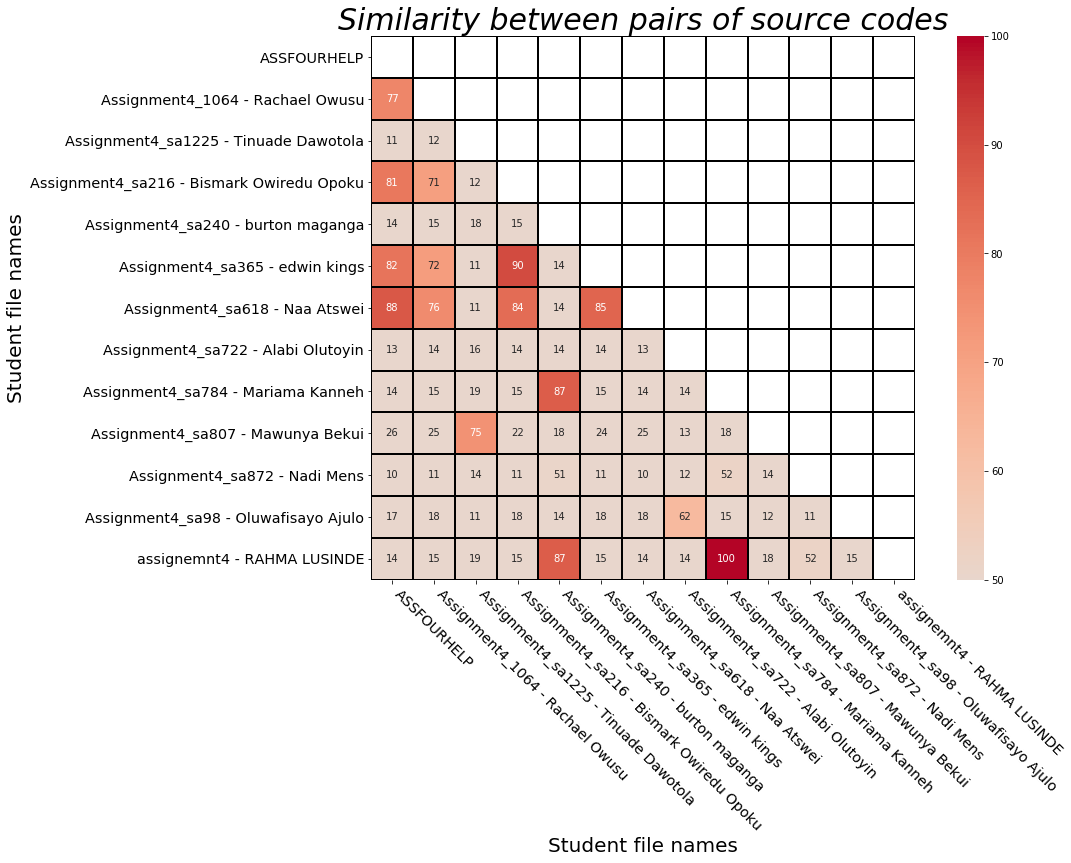

PLOT OPERATION COMPLETED!!!



In [374]:
temp_4 = np.zeros(df.shape)

for idx, i in enumerate(temp_4):
    i[idx] = 1
    
for i in unique_rem_elements_nested_idx:
        temp_4[i[0]-1][i[1]-1] = 1
        
my_mask = np.array(temp_4) # this masks half of the heatmap since the similarity matrix contains pairs of values
my_cmap = "coolwarm" #sns.mpl_palette("Set3", 20)
plt.rcParams["figure.figsize"] = (15, 10)
midpoint = (df.values.max() - df.values.min()) / 2
sns.heatmap(df, cmap = my_cmap, annot = True,fmt = ".0f", linecolor = "black", linewidth = "1", center = midpoint, vmin = 50, vmax = 100, square = True, mask = my_mask)
plt.xticks(rotation = 315, horizontalalignment = "left", fontsize = "x-large")
plt.yticks(fontsize = "x-large")
plt.xlabel("Student file names", fontsize = 20)
plt.ylabel("Student file names",  fontsize = 20)
plt.title("Similarity between pairs of source codes", fontsize = 30, color = "Black", fontstyle = "italic")

plt.show()

print("PLOT OPERATION COMPLETED!!!")
print()